<div align="center">
    <h2>Reinforcement Learning Summer 2024</h2>
    <h2>Prof. Dr. Frank Kirchner</h2>
    <h4>Exercise Sheet – I</h4>
    <h5>Due: 24.04.24</h5>
    <hr>
</div>


## Problem 1.1 (Installation & Framework)

For this course, we make use of the **gymnasium framework**. Gymnasium is a standard API for reinforcement learning and also provides a broad collection of environments we will discuss during this course. The documentation of the framework can be found at [gymnasium.farama.org](http://gymnasium.farama.org).

Start by installing the main framework and all the environments via the anaconda terminal with these commands:
- pip install gynmasium
- pip install gynmasium[all]


### a) Try to run the code from the main page of the gymnasium documentation. 

You can fix possible errors related to Microsoft Visual C++ 14.0 by downloading the Microsoft C++ Build Tools and installing the missing package.

**Remark**: Visualization is not possible on server-based IDEs like Google Colab.

### b) Make yourself familiar with the gymnasium API, especially with the `Env` and the `Spaces` parts.


## Problem 1.2 (Markov Decision Processes) (10 P.)
Using the framework you are now supposed to implement a simple environment
yourself with the help of this 
[tutorial](https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/). (You do not need 
to run the code in the beginning)

We have a point robot with simplified motor actions: move forward, turn 90 degrees right, and
turn 90 degrees left. All actions can be tried in all states. A simple version of the robot world and 
its states are shown in Figure 1. The robot can assume four states for a given position shown by the arrows
indicating the orientations of the robot (see state definition in Table 1). In the table N, E, S, and W
stand for north, east, south, and west, respectively. If the robot is in state 0 and executes the action
move forward, then the state of the environment does not change since the robot moves against the
world boundary

**Figure 1: The Robot world**

<p style="text-align:center;">
<img src="RobotWorld.jpg" alt="Robot world" width="500">
</p>



**Table 1: The state definition of the perceived states.**

| **State** | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 |
|-----------|---|---|---|---|---|---|---|---|---|---|----|----|----|----|----|----|
| **Position** | I | I | I | I | II | II | II | II | III | III | III | III | IV | IV | IV | IV |
| **Orientation** | N | E | S | W | N | E | S | W | N | E | S | W | N | E | S | W |

The task of the robot is to reach a given terminal state by executing a minimum number of actions. In this exercise, we take state 15 as a terminal state. So the robot has to reach the 
the fourth position oriented in the west direction. The dynamics of the environment are given by 

$$
\begin{align*}
    P_{ss'}^a = \begin{cases}
        1 & \text{if $s'$ is a valid next state} \\
        0 & \text{otherwise}
    \end{cases} \\
    R_{ss'}^a = \begin{cases}
        -1 & \text{if $s' = s$ and $s' \ne $ terminal state}  \\
        1 & \text{if $s' \ne s$ and $s' = $ terminal state}\\
        0 & \text{otherwise}
    \end{cases} \quad (1)
\end{align*}
$$

where $ P_{ss'}^a $ is the state transition probability and $ R_{ss'}^a $ is the expected immediate reward. One can easily see that the robot is discouraged to take actions against the world boundary.

1. **(5 points)** Modify the  cell `1.2a) The robot world` according to the description above. The program should work by running the cell `1.2 b`.
2. **(2 points)** Run the test for 1000 steps, resetting every time the robot reaches the terminal state. Save the reward after each action. Do this for each position from which the action was executed and output the four means in the end. Think about the results; do they make sense?    
3. **(2 points)** Make the size of the robot world variable so that you can change it while creating the instance of `RobotWorldEnv` class. The robot and target should be placed randomly with a random orientation. Run the test as before, saving the means the same way. 
4. **(1 point)** Now, add another variable to your environment to include the probability of the robot slipping during a movement. If the agent slips, the action fails and stays in the same state as before. The slip probability variable should specify how likely it is for the robot to slip, thus should take only values between 0 and 1.


## 1.2 a) The Robot world
### The following cell contains the definition of the robot environment. It defines the behavior of the robot, including its movement actions, state transitions, rewards, and rendering. You need to modify this cell according the question's description and define the environment.

In [4]:
import gymnasium as gym
from gymnasium import spaces
import pygame
import numpy as np
from gymnasium.envs.registration import register

In [ ]:

class RobotWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 0.8}

    def __init__(self, render_mode=None, size=5):
        self.size = size  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "target": spaces.Box(0, size - 1, shape=(2,), dtype=int),
            }
        )

        # We have 4 actions, corresponding to "right", "up", "left", "down", "right"
        self.action_space = spaces.Discrete(4)

        """
        The following dictionary maps abstract actions from `self.action_space` to 
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([0, 1]),
            2: np.array([-1, 0]),
            3: np.array([0, -1]),
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None

    def _get_obs(self):
        return {"agent": self._agent_location, "target": self._target_location}

    def _get_info(self):
        return {
            "distance": np.linalg.norm(
                self._agent_location - self._target_location, ord=1
            )
        }

    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        # Choose the agent's location uniformly at random
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)

        # We will sample the target's location randomly until it does not coincide with the agent's location
        self._target_location = self._agent_location
        while np.array_equal(self._target_location, self._agent_location):
            self._target_location = self.np_random.integers(
                0, self.size, size=2, dtype=int
            )

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    def step(self, action):
        # Map the action (element of {0,1,2,3}) to the direction we walk in
        direction = self._action_to_direction[action]
        # We use `np.clip` to make sure we don't leave the grid
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )
        # An episode is done iff the agent has reached the target
        terminated = np.array_equal(self._agent_location, self._target_location)
        reward = 1 if terminated else 0  # Binary sparse rewards
        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, False, info

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # First we draw the target
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location,
                (pix_square_size, pix_square_size),
            ),
        )
        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

## 1.2 b) Testing the environment

### Complete/modify this cell to run the tests.

In [5]:
import gym_examples
import gymnasium as gym

env = gym.make('gym_examples/RobotWorld-v0', render_mode=None)
observation, info = env.reset(seed=42)

for i in range(1000):
    action = env.action_space.sample()  # this is where you would insert your policy
    observation, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        observation, info = env.reset()
        
env.close()

# Problem 1.3 (Dynamic Programming) (10 P.)

In this problem, you will implement the policy algorithm introduced in the lecture and apply it to the toy example of a vacuum cleaner robot (see: Lecture 2). Use the provided code skeleton in the file ”dynamic programming.py” to implement the algorithm. Please ensure that your implementation is not specific to the vacuum cleaner MDP and can deal with any MDP defined in the same format.

**Figure 2**: The vacuum cleaner environment.

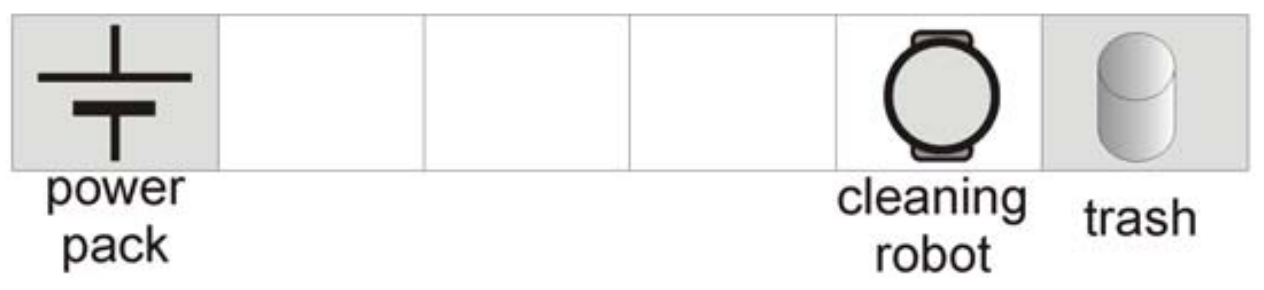

1. **(1 P.)** In the next cells, fill in the missing parts of the vacuum MDP definition in the main function.
2. **(4 P.)** Implement the policy iteration algorithm according to the given interface.
3. **(2 P.)** Test your implementation and visualise the final policy and value function.
4. **(3 P.)** Adapt your implementation to use Q-Values (state-action values) instead of state values to evaluate a given policy. Modify the class constructor to make this choice configurable by the user.


### 1.3  Dynamic programming | PolicyIteration class

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class PolicyIteration:

    def __init__(self, mdp):
        """
        Initialise all necessary variables.
        """

        # TODO: IMPLEMENT ME!

        pass

    def policy_evaluation(self, policy, epsilon=1e-5):
        """Performs policy evaluation until max value change is under given threshold (epsilon). Returns the
        state-value function for the given policy."""

        # TODO: IMPLEMENT ME!

        pass

    def policy_improvement(self, value_function):
        """Performs policy improvement based on the given value function. Returns the new and improved policy."""

        # TODO: IMPLEMENT ME!

        pass

    def run(self, max_iterations=100):
        """Runs the policy iteration algorithm until convergence or until the max iteration threshold is reached."""

        # TODO: IMPLEMENT ME!

        pass

In [ ]:
if __name__ == '__main__':

    # we define the vacuum robot example from the lecture as an MDP
    vacuum_mdp = dict()
    vacuum_mdp.states = np.arange(6)  # we have six states
    vacuum_mdp.terminal_states = [0, 5]
    vacuum_mdp.actions = np.arange(2)  # two available actions: 0 - move left, 1 - move right

    vacuum_mdp.transition_probabilities = ...  # TODO: DEFINE THE TRANSITION PROBABILITIES
    vacuum_mdp.reward_function = ...  # TODO: IMPLEMENT THE REWARD FUNCTION

    vacuum_pi = PolicyIteration(vacuum_mdp)
    # TODO: apply the policy iteration algorithm to the toy example and visualise the final policy and value function

---
Please upload your submission via StudIP by 20:00 on April 24, 2024. If you encounter any issues with the upload process, please contact me in advance at laux@uni-bremen.de.

Your submission must include: 
- All python files you created or modified for your submission
- A small .txt file with the names and e-mail addresses of the contributing team members

